I choosed Titanic Dataset which contain information did the person survived or not in Titanic disaster with some additional information about each person.

### Steps
1. Choose a binary dataset
2. Perform exploratory data analysis
3. binarize  the features (data scaling)
4. Split train-test and calculate metrics
5. Compare the achieved performance with other standard classification methods
<!-- 6. Improve classification -->
<!-- 7. Report -->
<!-- 8. Upload -->

In [1]:
### Import all dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

### Step 1
1. load and show dataset
2. choose features columns for classification 

In [2]:
df = pd.read_csv('/kaggle/input/fca-dataset/Titanic-Dataset.csv')
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
375,376,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,1,0,PC 17604,82.1708,NaN,C
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
435,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,S
562,563,0,2,"Norman, Mr. Robert Douglas",male,28.0,0,0,218629,13.5000,NaN,S
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S


In [3]:
# since there are a lot of values in Cabin categorical feature, let's choose main part of cabin
def choose_letter_cabin(x):
    return str(x)[0]

In [4]:
df['Cabin'] = df['Cabin'].apply(choose_letter_cabin)

In [5]:
### we will drop PassengerId, Name and Ticket since those columns do not contain relevent information
df = df[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']]
df.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
137,0,1,male,37.0,1,0,53.1000,C,S
453,1,1,male,49.0,1,0,89.1042,C,C
255,1,3,female,29.0,0,2,15.2458,n,C
845,0,3,male,42.0,0,0,7.5500,n,S
45,0,3,male,NaN,0,0,8.0500,n,S


### Step 2
1. Split features on 3 tips: binary, categorical, numerical
2. Vizualize and describe the data

In [6]:
target = 'Survived'
binary_features = ['Sex']
categorical_features = ['Pclass','SibSp','Parch','Cabin','Embarked']
numerical_features = ['Age','Fare']

In [11]:
def vizualize_categorical(df, target, categorical_features):
    n = len(categorical_features)
    fig = plt.figure(figsize=(12, n*6))

    # fig = plt.figure()
    arr_ax = []
    for i in range(n*2):
        arr_ax.append(fig.add_subplot(100*n+20+i+1))

    df_pos = df[df[target]==1]
    df_neg = df[df[target]==0]

    for i in range(n):
        
        value_counts_names = list(df_pos[categorical_features[i]].value_counts().index)
        value_counts_values  = list(df_pos[categorical_features[i]].value_counts())
        value_counts_names, list2 = zip(*sorted(zip(value_counts_names, value_counts_values)))

        arr_ax[i*2].bar(value_counts_names, value_counts_values)
        arr_ax[i*2].set_xlabel(categorical_features[i])
        arr_ax[i*2].set_ylabel('count')
        arr_ax[i*2].title.set_text(f'Distribution of {categorical_features[i]} with target==1')

        value_counts_names = list(df_neg[categorical_features[i]].value_counts().index)
        value_counts_values  = list(df_neg[categorical_features[i]].value_counts())
        value_counts_names, list2 = zip(*sorted(zip(value_counts_names, value_counts_values)))

        arr_ax[i*2+1].bar(value_counts_names, value_counts_values)
        arr_ax[i*2+1].set_xlabel(categorical_features[i])
        arr_ax[i*2+1].set_ylabel('count')
        arr_ax[i*2+1].title.set_text(f'Distribution of {categorical_features[i]} with target==0')
    plt.show()
        

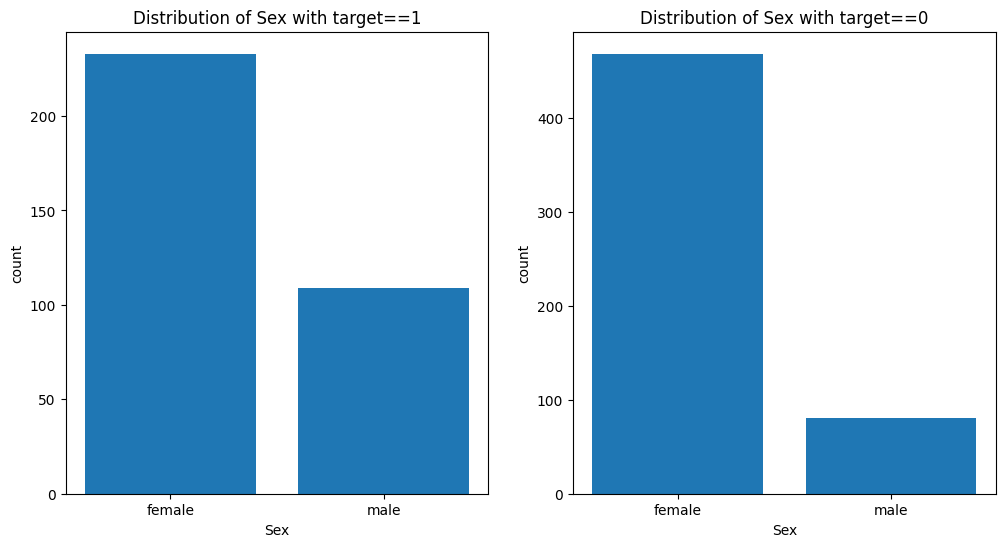

In [8]:
vizualize_categorical(df, target, binary_features)

## Feature: Sex: the gender of the passenger

As we can see with target equal to 1 (passenger survived) there is higher propabaility to be male, comared to 0 target. So if passenger is male statistically he has a higher chance to survive

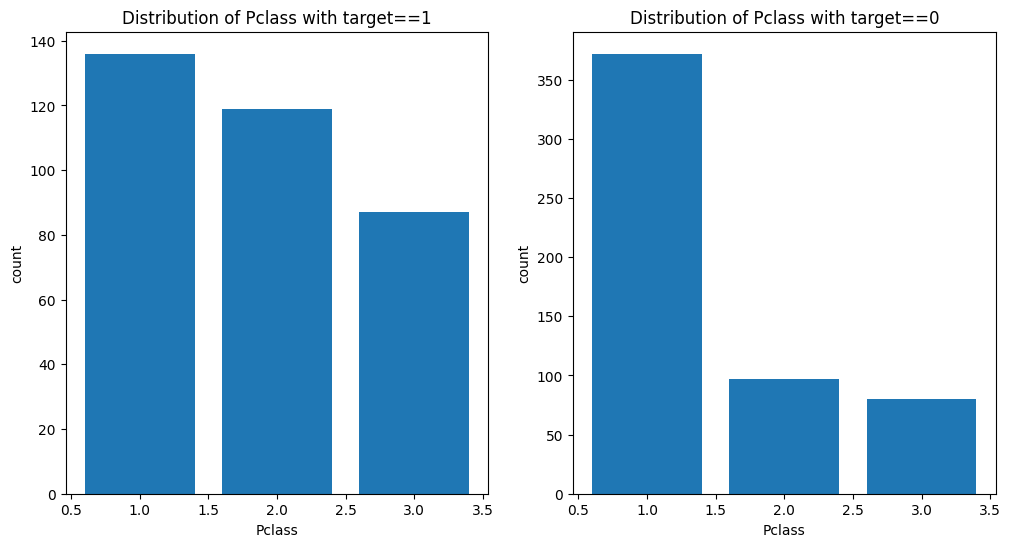

In [9]:
vizualize_categorical(df, target, categorical_features[0:1])

## Feature: Pclass: Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd

As we can see with target equal to 1 (passenger survived) there is higher with 2 and 3 class, comared to 0 target. So if passenger has 2 and 3 class statistically he/she has a higher chance to survive

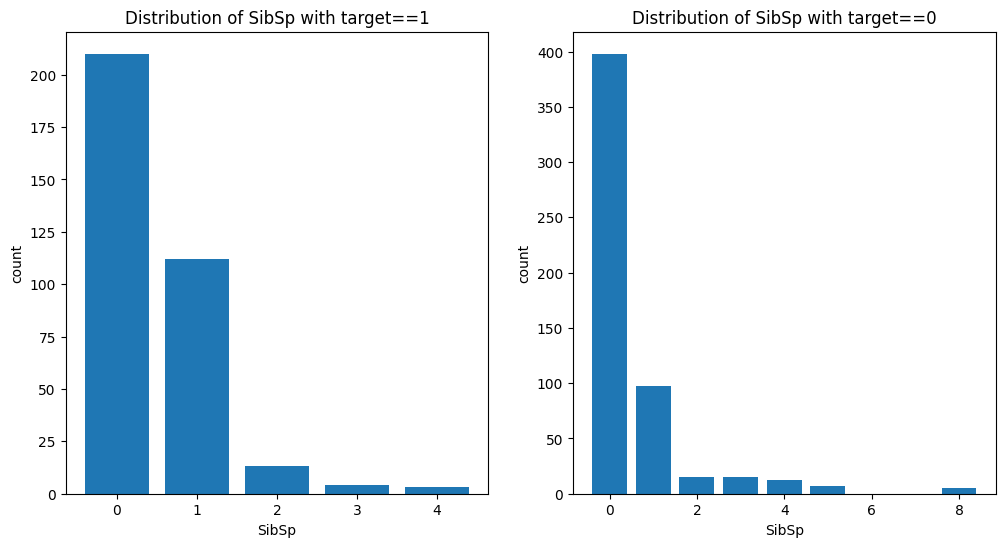

In [10]:
vizualize_categorical(df, target, categorical_features[1:2])

## Feature: SibSp: No. of siblings / spouses aboard the Titanic

Feature shows number of siblings aboard. From bars above we can conclude that in survived people there are relatively more persons with non zero numer of siblings

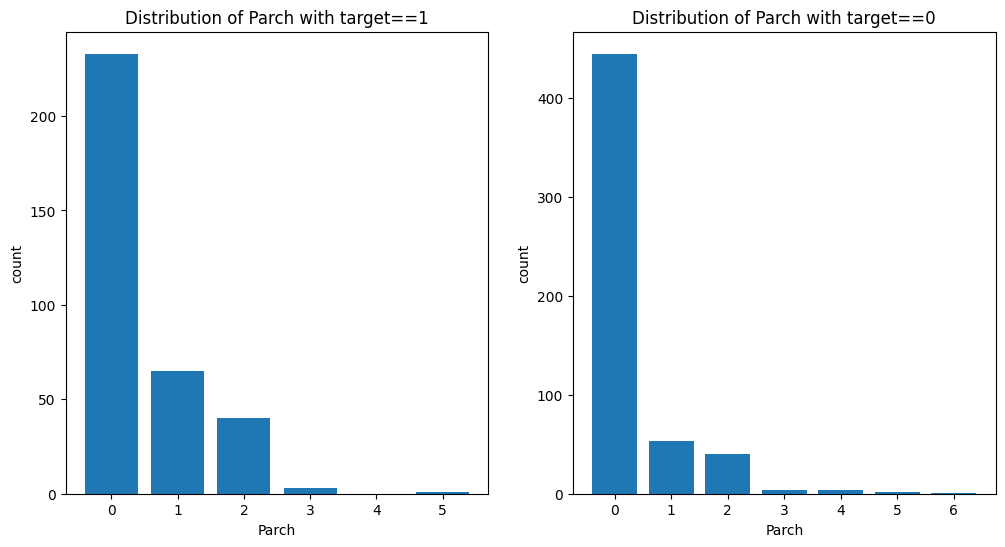

In [11]:
vizualize_categorical(df, target, categorical_features[2:3])

## Feature: Parch: No. of parents / children aboard the Titanic

Feature shows number of parents / children aboard. From bars above we can conclude that in survived people there are relatively more persons with non zero numer of parents / children aboard.

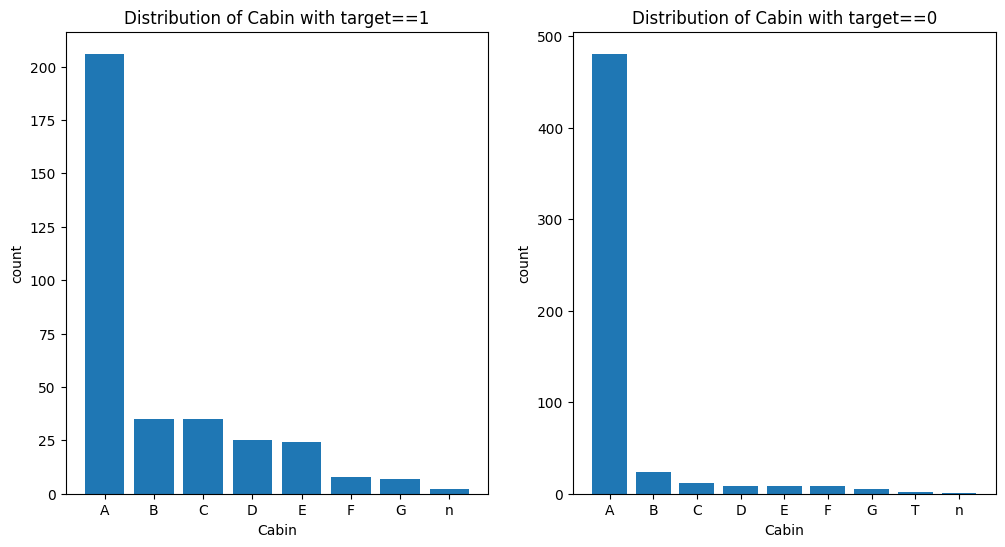

In [12]:
vizualize_categorical(df, target, categorical_features[3:4])

## Feature: Cabin: Main part of Cabin (letter)

Feature shows the main letter of the cabin (cabins with equal letter located nearly). From bars above we can conclude that with cabins different from A there more chance to survive. 

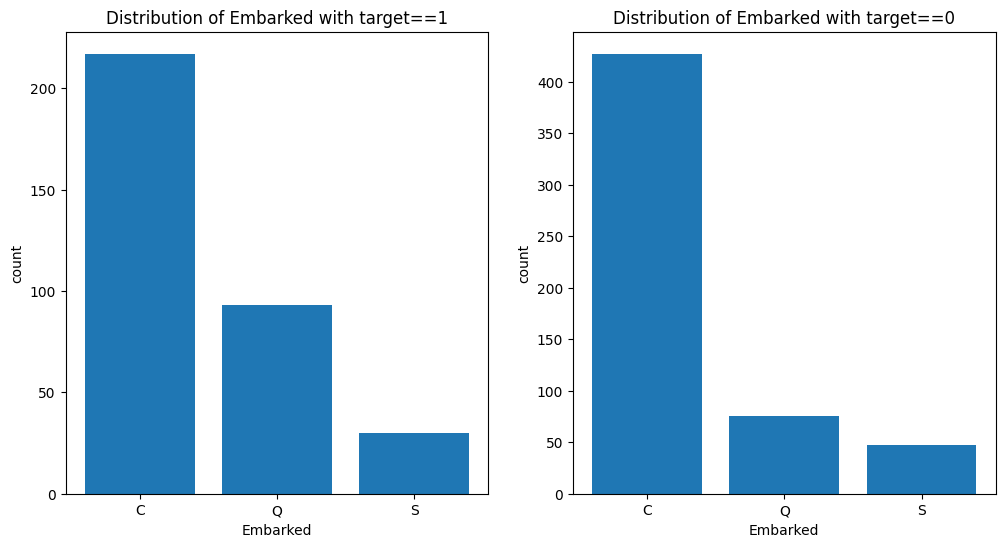

In [12]:
vizualize_categorical(df, target, categorical_features[4:5])

## Feature: Embarked: Port of Embarkation:C = Cherbourg, Q = Queenstown, S = Southampton

Feature shows the Port of Embarkation. From bars above we can conclude that passengers from Queenstown statistically hac more chance to survive. 

In [14]:
def vizualize_numerical(df, target, numerical_features, apply_log):
    n = len(numerical_features)
    fig = plt.figure(figsize=(12, n*6))

    # fig = plt.figure()
    arr_ax = []
    for i in range(n*2):
        # print(100*n+20+i+1)
        arr_ax.append(fig.add_subplot(100*n+20+i+1))

    df_pos = df[df[target]==1]
    df_neg = df[df[target]==0]

    for i in range(n):
        # value_counts_names = list(df_pos[categorical_features[i]].value_counts().index)
        # value_counts_values  = list(df_pos[categorical_features[i]].value_counts())
        if apply_log[i]:
            values = np.log(1+np.array(df_pos[numerical_features[i]]))
        else:
            values = np.array(df_pos[numerical_features[i]])
        
        arr_ax[i*2].hist(values,bins=30,density=True)
        arr_ax[i*2].set_xlabel(numerical_features[i])
        arr_ax[i*2].set_ylabel('count')
        arr_ax[i*2].title.set_text(f'Distribution of {numerical_features[i]} with target==1')

        # value_counts_names = list(df_neg[categorical_features[i]].value_counts().index)
        # value_counts_values  = list(df_neg[categorical_features[i]].value_counts())

        if apply_log[i]:
            values = np.log(1+np.array(df_neg[numerical_features[i]]))
        else:
            values = np.array(df_neg[numerical_features[i]])
            
        # values = np.array(df_neg[numerical_features[i]])
        
        arr_ax[i*2+1].hist(values,bins=30,density=True)
        arr_ax[i*2+1].set_xlabel(numerical_features[i])
        arr_ax[i*2+1].set_ylabel('count')
        arr_ax[i*2+1].title.set_text(f'Distribution of {numerical_features[i]} with target==0')
    plt.show()
        

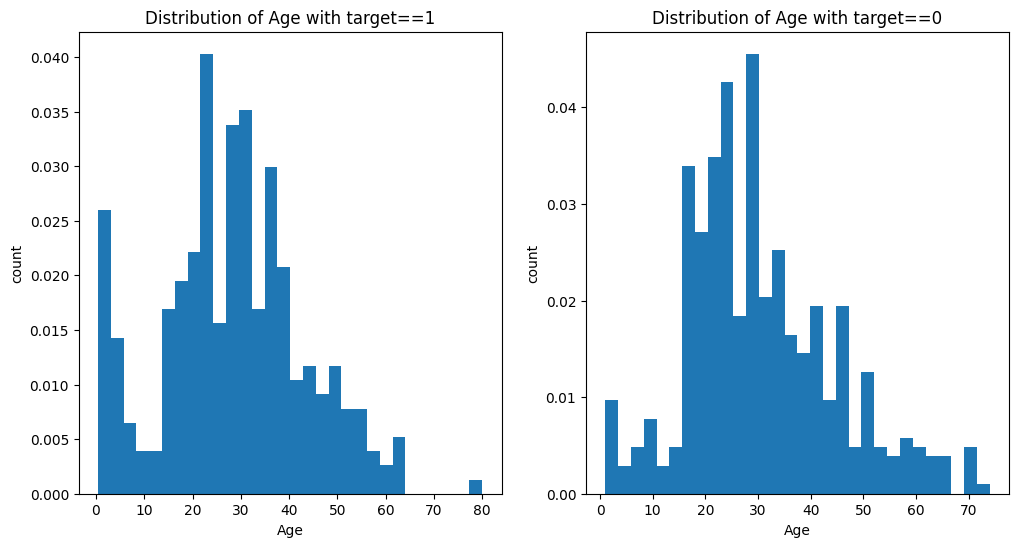

In [15]:
vizualize_numerical(df, target, numerical_features[0:1], [False])

## Feature: Age: Age in Years

Feature shows the Age in Years of passengers. From bars above we can conclude that passengers from 0 to 10 years has more chance to survive.

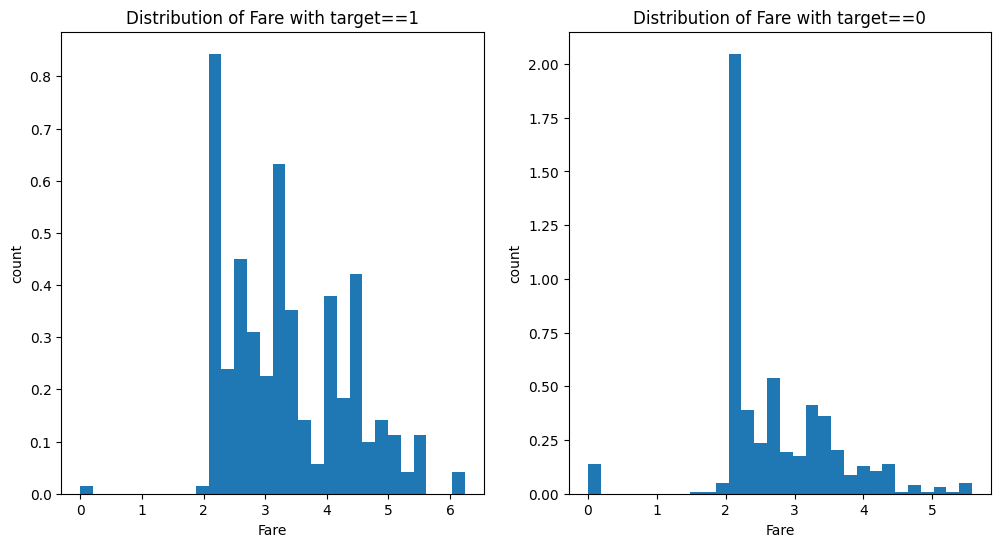

In [16]:
vizualize_numerical(df, target, numerical_features[1:2], [True])

## Feature: Fare: Passenger fare

Feature shows the Fare which passengers paid for trip. I have applayed log transformation to get distridution close to normal one.

### Step 3
1. Prepare nominal scales features (with more than 2 possible values) ('Pclass','SibSp','Parch','Cabin','Embarked')
2. Prepare ordinal scales features (for numerical features) ('Age','Fare')
3. prepare dichotomic scale features  ('Sex')

In [17]:
def create_nominal_scale_features(df,features):
    arr_df = []
    for i in range(len(features)):
        df_cur = df[[features[i]]].copy()
        values = np.unique(df_cur[features[i]].astype(str))
        # print(values)
        for value in values:
            df_cur[f'{features[i]}=={value}'] = np.array(df_cur[features[i]].astype(str)==value)
        df_cur = df_cur.drop([features[i]],axis=1)
        arr_df.append(df_cur)
        
    return pd.concat(arr_df,axis=1).reset_index()

In [18]:
df_nominal = create_nominal_scale_features(df,categorical_features)
df_nominal.sample(5)

,index,Pclass==1,Pclass==2,Pclass==3,SibSp==0,SibSp==1,SibSp==2,SibSp==3,SibSp==4,SibSp==5,...,Cabin==D,Cabin==E,Cabin==F,Cabin==G,Cabin==T,Cabin==n,Embarked==C,Embarked==Q,Embarked==S,Embarked==nan
571,571,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
521,521,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
181,181,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False
433,433,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
430,430,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [19]:
def create_ordinal_scale_features(df, features, bounds, apply_log):
    arr_df = []
    for i in range(len(features)):
        df_cur = df[[features[i]]].copy()
        df_cur = df_cur.fillna(0).astype(float)
        if apply_log[i]:
            df_cur[features[i]] = np.log(1+np.array(df_cur[features[i]]))
        else:
            df_cur[features[i]] = np.array(df_cur[features[i]])
            
        for bound in bounds[i]:
            df_cur[f'{features[i]}<={bound}'] = np.array(df_cur[features[i]]<=bound)
        df_cur = df_cur.drop([features[i]],axis=1)
        arr_df.append(df_cur)
        
    return pd.concat(arr_df,axis=1).reset_index()

In [20]:
df_ordinal = create_ordinal_scale_features(df, numerical_features, [[12,25,35,45,55,65,75],[2.3,3.3,4,5,6]], [False,True])
df_ordinal.sample(5)

,index,Age<=12,Age<=25,Age<=35,Age<=45,Age<=55,Age<=65,Age<=75,Fare<=2.3,Fare<=3.3,Fare<=4,Fare<=5,Fare<=6
110,110,False,False,False,False,True,True,True,False,False,True,True,True
431,431,True,True,True,True,True,True,True,False,True,True,True,True
647,647,False,False,False,False,False,True,True,False,False,True,True,True
59,59,True,True,True,True,True,True,True,False,False,True,True,True
216,216,False,False,True,True,True,True,True,True,True,True,True,True


In [21]:
def create_dichotomic_scale_features(df,features):
    arr_df = []
    for i in range(len(features)):
        df_cur = df[[features[i]]].copy()
        values = np.unique(df_cur[features[i]].astype(str))
        # print(values)
        df_cur[f'{features[i]} is {values[0]}'] = np.array(df_cur[features[i]].astype(str)==values[0])
        df_cur[f'{features[i]} not is {values[0]}'] = np.array(df_cur[features[i]].astype(str)!=values[0])
        df_cur = df_cur.drop([features[i]],axis=1)
        arr_df.append(df_cur)
        
    return pd.concat(arr_df,axis=1).reset_index()

In [22]:
df_dichotomic = create_dichotomic_scale_features(df, binary_features)
df_dichotomic.sample(5)

,index,Sex is female,Sex not is female
827,827,False,True
360,360,False,True
307,307,True,False
796,796,True,False
204,204,False,True


In [23]:
df_binarization = pd.concat([df_nominal,df_ordinal,df_dichotomic],axis=1)
df_binarization.sample(5)

,index,Pclass==1,Pclass==2,Pclass==3,SibSp==0,SibSp==1,SibSp==2,SibSp==3,SibSp==4,SibSp==5,...,Age<=65,Age<=75,Fare<=2.3,Fare<=3.3,Fare<=4,Fare<=5,Fare<=6,index,Sex is female,Sex not is female
384,384,False,False,True,True,False,False,False,False,False,...,True,True,True,True,True,True,True,384,False,True
240,240,False,False,True,False,True,False,False,False,False,...,True,True,False,True,True,True,True,240,True,False
618,618,False,True,False,False,False,True,False,False,False,...,True,True,False,False,True,True,True,618,True,False
87,87,False,False,True,True,False,False,False,False,False,...,True,True,True,True,True,True,True,87,False,True
431,431,False,False,True,False,True,False,False,False,False,...,True,True,False,True,True,True,True,431,True,False


### Step 4
1. Split dataset into train-test
2. Write functions to calculate metrics
3. Apply lazy fca algorithm

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_binarization, 
                                                    df['Survived'], 
                                                    test_size=0.2, 
                                                    stratify=df['Survived'], 
                                                    random_state=42)

In [173]:
class LazyClassifierFCA:
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train
        
    def classify_sample(self, sample: pd.Series):
        # Split X_train into positive and negative classes
        X_train_positive = self.X_train[y_train == 1]
        X_train_negative = self.X_train[y_train == 0]
        
        positive_classifiers = 0
        negative_classifiers = 0
        
        # Function to check if intersection with a train sample is a positive classifier
        def is_positive_classifier(intersection):
            # Find samples in X_train_positive that contain the intersection
            num_positive = ((X_train_positive | ~intersection) == True).all(axis=1).sum()
            num_negative = ((X_train_negative | ~intersection) == True).all(axis=1).sum()
            return num_negative == 0 and num_positive > 1
        
        # Function to check if intersection is a negative classifier
        def is_negative_classifier(intersection):
            # Find samples in X_train_negative that contain the intersection
            num_positive = ((X_train_positive | ~intersection) == True).all(axis=1).sum()
            num_negative = ((X_train_negative | ~intersection) == True).all(axis=1).sum()
            return num_positive == 0 and num_negative > 1
        
        # Check for positive classifiers by intersecting sample with each positive object
        for _, pos_sample in X_train_positive.iterrows():
            intersection = sample & pos_sample
            if is_positive_classifier(intersection):
                positive_classifiers += 1

        # Check for negative classifiers by intersecting sample with each negative object
        for _, neg_sample in X_train_negative.iterrows():
            intersection = sample & neg_sample
            if is_negative_classifier(intersection):
                negative_classifiers += 1

        # Determine the class based on the number of classifiers
        if positive_classifiers > negative_classifiers:
            print(f"sample {sample.name} is classified as 1, {positive_classifiers=}, {negative_classifiers=}")
            return 1  # Predict positive
            
        elif negative_classifiers > positive_classifiers:
            print(f"sample {sample.name} is classified as 0, {positive_classifiers=}, {negative_classifiers=}")
            return 0  # Predict negative

        else:
            # If equal, you can decide on a rule, like defaulting to 0 or 1, or returning 'undetermined'
            print(f"sample {sample.name} is classified as 0, default, {positive_classifiers=}, {negative_classifiers=}")
        
            return 0  
            # or 0, depending on the choice


    def predict(self, X_test: pd.DataFrame):
        # List to store predictions for each test sample
        predictions = []
        
        # Iterate through each sample in X_test
        for _, sample in X_test.iterrows():
            # Classify the sample and append the result to predictions
            prediction = self.classify_sample(sample)
            predictions.append(prediction)
        
        return predictions

In [174]:
fca_classifier = LazyClassifierFCA()
fca_classifier.fit(X_train, y_train)

In [175]:
%%time
y_pred_fca = fca_classifier.predict(X_test)

sample 565 is classified as 0, positive_classifiers=0, negative_classifiers=8
sample 160 is classified as 0, positive_classifiers=0, negative_classifiers=1
sample 553 is classified as 0, default, positive_classifiers=0, negative_classifiers=0
sample 860 is classified as 0, positive_classifiers=0, negative_classifiers=9
sample 241 is classified as 1, positive_classifiers=3, negative_classifiers=0
sample 559 is classified as 0, default, positive_classifiers=0, negative_classifiers=0
sample 387 is classified as 0, default, positive_classifiers=0, negative_classifiers=0
sample 536 is classified as 0, positive_classifiers=0, negative_classifiers=4
sample 698 is classified as 1, positive_classifiers=2, negative_classifiers=1
sample 99 is classified as 0, default, positive_classifiers=0, negative_classifiers=0
sample 126 is classified as 0, default, positive_classifiers=0, negative_classifiers=0
sample 333 is classified as 0, positive_classifiers=0, negative_classifiers=8
sample 216 is classi

In [189]:
def calculate_metrics(name,y_pred,y_true):
    true_positive = np.sum((y_pred==1)&(y_true==1))
    true_negative = np.sum((y_pred==0)&(y_true==0))
    false_positive = np.sum((y_pred==1)&(y_true==0))
    false_negative = np.sum((y_pred==0)&(y_true==1))
    
    Specificity = true_negative / (true_negative + false_positive)
    npv = true_negative/ (true_negative + false_negative)
    fpr = false_positive / (false_positive + true_negative)
    fdr = false_negative / (false_negative + true_positive)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics = pd.DataFrame({"True Positive":[true_positive],
                         "True Negative":[true_negative],
                         "False Positive":[false_positive],
                         "False Negative":[false_negative],
                         "Negative Predictive Value":[npv],
                         "False Positive Rate":[fpr],
                         "False Discovery Rate":[fdr],
                         "accuracy":[accuracy],
                         "precision":[precision],
                         "recall":[recall],
                         "f1":[f1],
                        })
    metrics.index = [name]
    return metrics
    

In [191]:
fca_metrics = calculate_metrics('fca',np.array(y_pred_fca),y_test)
fca_metrics

,True Positive,True Negative,False Positive,False Negative,Negative Predictive Value,False Positive Rate,False Discovery Rate,accuracy,precision,recall,f1
fca,41,98,12,28,0.777778,0.109091,0.405797,0.776536,0.773585,0.594203,0.672131


### Step 5
1. KNN
2. Logistic Regression
3. Decision Tree
4. Random Forest
5. XGBoost

In [219]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [204]:
seed = 42

column_transformer = ColumnTransformer(
    transformers=[
        (
            "ohe",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            binary_features+categorical_features,
        ),
        ("scaling", StandardScaler(), numerical_features),
    ],
    remainder="passthrough",
)

In [207]:
df['Fare'] = df['Fare'].fillna(0).astype(float)
df['Age'] = df['Age'].fillna(0).astype(float)

In [199]:
df['Fare'] = np.log(1+df['Fare'])

In [208]:
X_train, X_test, y_train, y_test = train_test_split(df[binary_features+categorical_features+numerical_features], df['Survived'], test_size=0.2, stratify=df['Survived'], random_state=42)

In [210]:
# knn
knn_classifier = Pipeline(
    steps=[
        ("ohe_and_scaling", column_transformer),
        ("KNN", KNeighborsClassifier(n_neighbors=5),),]
)

knn_classifier.fit(X_train, y_train)

Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex', 'Pclass', 'SibSp',
                                                   'Parch', 'Cabin',
                                                   'Embarked']),
                                                 ('scaling', StandardScaler(),
                                                  ['Age', 'Fare'])])),
                ('KNN', KNeighborsClassifier())])

In [212]:
%%time
y_pred_knn = knn_classifier.predict(X_test)

CPU times: user 50.3 ms, sys: 4.98 ms, total: 55.3 ms
Wall time: 24.5 ms


In [213]:
knn_metrics = calculate_metrics('knn',np.array(y_pred_knn),y_test)
knn_metrics

,True Positive,True Negative,False Positive,False Negative,Negative Predictive Value,False Positive Rate,False Discovery Rate,accuracy,precision,recall,f1
knn,46,94,16,23,0.803419,0.145455,0.333333,0.782123,0.741935,0.666667,0.70229


In [220]:
# Decision Tree
DecisionTree_classifier = Pipeline(
    steps=[
        ("ohe_and_scaling", column_transformer),
        ("DecisionTree", DecisionTreeClassifier(),),]
)

DecisionTree_classifier.fit(X_train, y_train)

Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex', 'Pclass', 'SibSp',
                                                   'Parch', 'Cabin',
                                                   'Embarked']),
                                                 ('scaling', StandardScaler(),
                                                  ['Age', 'Fare'])])),
                ('KNN', DecisionTreeClassifier())])

In [221]:
%%time
y_pred_dt = DecisionTree_classifier.predict(X_test)

CPU times: user 8.67 ms, sys: 2.01 ms, total: 10.7 ms
Wall time: 9.13 ms


In [222]:
dt_metrics = calculate_metrics('decision tree',np.array(y_pred_dt),y_test)
dt_metrics

,True Positive,True Negative,False Positive,False Negative,Negative Predictive Value,False Positive Rate,False Discovery Rate,accuracy,precision,recall,f1
decision tree,47,93,17,22,0.808696,0.154545,0.318841,0.782123,0.734375,0.681159,0.706767


In [223]:
# Logistic Regression
LogisticRegression_classifier = Pipeline(
    steps=[
        ("ohe_and_scaling", column_transformer),
        ("LogisticRegression", LogisticRegression(),),]
)

LogisticRegression_classifier.fit(X_train, y_train)

Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex', 'Pclass', 'SibSp',
                                                   'Parch', 'Cabin',
                                                   'Embarked']),
                                                 ('scaling', StandardScaler(),
                                                  ['Age', 'Fare'])])),
                ('KNN', LogisticRegression())])

In [224]:
%%time
y_pred_lr = LogisticRegression_classifier.predict(X_test)

CPU times: user 6.11 ms, sys: 3.96 ms, total: 10.1 ms
Wall time: 8.84 ms


In [225]:
lr_metrics = calculate_metrics('logistic regression',np.array(y_pred_lr),y_test)
lr_metrics

,True Positive,True Negative,False Positive,False Negative,Negative Predictive Value,False Positive Rate,False Discovery Rate,accuracy,precision,recall,f1
logistic regression,48,98,12,21,0.823529,0.109091,0.304348,0.815642,0.8,0.695652,0.744186


In [226]:
# Random Forest
RandomForest_classifier = Pipeline(
    steps=[
        ("ohe_and_scaling", column_transformer),
        ("LogisticRegression", RandomForestClassifier(),),]
)

RandomForest_classifier.fit(X_train, y_train)

Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex', 'Pclass', 'SibSp',
                                                   'Parch', 'Cabin',
                                                   'Embarked']),
                                                 ('scaling', StandardScaler(),
                                                  ['Age', 'Fare'])])),
                ('LogisticRegression', RandomForestClassifier())])

In [227]:
%%time
y_pred_rf = RandomForest_classifier.predict(X_test)

CPU times: user 18.6 ms, sys: 1.01 ms, total: 19.6 ms
Wall time: 18.3 ms


In [228]:
rf_metrics = calculate_metrics('random forest',np.array(y_pred_rf),y_test)
rf_metrics

,True Positive,True Negative,False Positive,False Negative,Negative Predictive Value,False Positive Rate,False Discovery Rate,accuracy,precision,recall,f1
random forest,50,97,13,19,0.836207,0.118182,0.275362,0.821229,0.793651,0.724638,0.757576


In [236]:
# xgboost

param_dist = {
    'objective':'binary:logistic',
    'n_estimators' : 15
}

xgboost_classifier = Pipeline(
    steps=[
        ("ohe_and_scaling", column_transformer),
        ("LogisticRegression", xgb.XGBClassifier(**param_dist),),]
)

xgboost_classifier.fit(X_train, y_train)

Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex', 'Pclass', 'SibSp',
                                                   'Parch', 'Cabin',
                                                   'Embarked']),
                                                 ('scaling', StandardScaler(),
                                                  ['Age', 'Fare'])])),
                ('LogisticRegression',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_byl...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=15, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [237]:
%%time
y_pred_xgb = xgboost_classifier.predict(X_test)

CPU times: user 9.59 ms, sys: 1.01 ms, total: 10.6 ms
Wall time: 9.52 ms


In [238]:
xgb_metrics = calculate_metrics('xgboost',np.array(y_pred_xgb),y_test)
xgb_metrics

,True Positive,True Negative,False Positive,False Negative,Negative Predictive Value,False Positive Rate,False Discovery Rate,accuracy,precision,recall,f1
xgboost,45,97,13,24,0.801653,0.118182,0.347826,0.793296,0.775862,0.652174,0.708661


In [241]:
metrics = pd.concat([
    fca_metrics,
    knn_metrics,
    dt_metrics, 
    lr_metrics,
    rf_metrics, 
    xgb_metrics
], axis=0)
metrics

,True Positive,True Negative,False Positive,False Negative,Negative Predictive Value,False Positive Rate,False Discovery Rate,accuracy,precision,recall,f1
fca,41,98,12,28,0.777778,0.109091,0.405797,0.776536,0.773585,0.594203,0.672131
knn,46,94,16,23,0.803419,0.145455,0.333333,0.782123,0.741935,0.666667,0.702290
decision tree,47,93,17,22,0.808696,0.154545,0.318841,0.782123,0.734375,0.681159,0.706767
logistic regression,48,98,12,21,0.823529,0.109091,0.304348,0.815642,0.800000,0.695652,0.744186
random forest,50,97,13,19,0.836207,0.118182,0.275362,0.821229,0.793651,0.724638,0.757576
xgboost,45,97,13,24,0.801653,0.118182,0.347826,0.793296,0.775862,0.652174,0.708661
